In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
import feather

In [3]:
PATH = "data/bulldozers/"
!ls {PATH} #what is in the path? 

Train.csv


In [4]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

## Import Data

In [54]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=["saledate"])

display_all(df_raw.tail().transpose())

In [55]:
#This Kaggle is evaluated on RMSLE (root mean squared log error) between actual and predicted Price
#for price, the %change (ratios) is more important
df_raw.SalePrice = np.log(df_raw.SalePrice)

## Preprocessing & Save
#### RF requires all numerical data

In [ ]:
#create an instance of the object
#then fit to the trainig data

m = RandomForestRegressor(n_jobs = -1)
m.fit(df_raw.drop('SalePrice', 1), df_raw.SalePrice)

#we will see errors here b/c 
#could not convert string to float 
## RandomForests require all numbers as inputs

#From Fast.AI --- 

??add_datepart 
#pulls interesting fields out of a dt object
??train_cats 
#converts strings to categorical values --- LABEL ENCODING
??apply_cats
#will use the same mapping of train_cats and apply to CV/testsets

#### Deal with Dates

In [58]:
df_raw['saledate']  #dtype: datetime64[ns] 
#apply add_datepart
add_datepart(df_raw, 'saledate')

#date treatment -- very valuable; we can pull a lot out of this 
??add_datepart

fld=df_raw.saledate
fld.dt. (and Tab)  
you can see the list of posible things you can get from a dt.type object  
add_datepart function will give you some default ones  
(this will add a LOT of columns)

#saledate has been replaced by a bunch of other stuff at the end 
df_raw.columns.values

#### Label Encoding

In [59]:
train_cats(df_raw)

In [60]:
#to check the mapping of categorical variables 
df_raw['UsageBand'].cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [61]:
#these are not in a sensible order --- let's change that: 
df_raw['UsageBand'].cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
#"inplace", instead of returning a new dataframe, will change the existing

#in practice, RandomForests are not too sensitive to Ordinal data... 
#does not matter that much if it is reordered... so if you don't check the data that carefully that's ok for now

In [ ]:
#this is what the model will see --> notice there are -1's (missing data)
df_raw['UsageBand'].cat.codes

#### Missing Values

In [62]:
# check %of missing values
df_raw.isnull().sum().sort_index()/len(df_raw)

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

#### save to FEATHER

#to_feather: very fast way to safe

os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

## Read data

In [5]:
df_raw=feather.read_dataframe('tmp/bulldozers-raw')

In [22]:
df_raw.shape

(401125, 65)

In [6]:
df, y, nas = proc_df(df_raw, 'SalePrice')

df.columns

In [24]:
df.shape ##added a couple NA columns, and got rid of Y

(401125, 66)

## Define functions

In [7]:
def split_vals(a,n):
    return a[:n].copy(), a[n:].copy()
n_valid = 12000 #set aside 12000 - same as Kaggle's test set size 
n_trn = len(y)-n_valid #get the index of where to split; this is b/c we want the latest dates
raw_train, raw_valid = split_vals(df_raw, n_trn)

#kaggle is scoring this based on RMSE 
def rmse(predicted, actual): 
    return math.sqrt(((predicted-actual)**2).mean())

def print_score(m):
    res = [round(rmse(m.predict(X_train), y_train), 4), 
           round(rmse(m.predict(X_valid), y_valid), 4),
           round(m.score(X_train, y_train)*100, 4), 
           round(m.score(X_valid, y_valid)*100, 4)]
    if hasattr(m, 'oob_score_'): 
        res.append(round(m.oob_score_*100, 4))
    print(res)

?hasattr

In [8]:
X_train, X_valid = split_vals(df, n_trn) #66 features 
y_train, y_valid = split_vals(y, n_trn)
X_train.shape

(389125, 66)

## 1. Base model

In [27]:
m = RandomForestRegressor(n_jobs = -1, n_estimators = 10)
m.fit(X_train, y_train)
print_score(m)

[0.2095, 0.2634, 90.827, 87.6064]


#### *take a subset of the training set to speed up*

In [28]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [29]:
m = RandomForestRegressor(n_jobs = -1, n_estimators = 10)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5.23 s, sys: 113 µs, total: 5.23 s
Wall time: 1.2 s
[0.0374, 0.3585, 99.6934, 77.0417]


### Single Tree

In [30]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5229, 0.5829, 40.0734, 39.3317]


this does not work:  
draw_tree(m.estimators_[0], df_trn, precision=3)

how do you decide which feature to split on? and which value? 
* weighted average MSE (check every feature and every value available, we check which one has the best MSE)
* you stop either when you meet a limit (max_depth), or when leafnodes have only x nodes in them 

In [31]:
# we can do this until the very end, we've covered all the possible features/splits
#and we would achive a training R^2 of 1 
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0, 0.4694, 100.0, 60.6502]


### Bagging  
Bag of Little Bootstraps (random forest is a way of bagging trees) 
* samples will be done randomly, with replacement (that will get about 65% of the rows, and a bunch of them represented multiple times)
* we will create 10 different models, each of which were only slightly predictive; but they're as different as possible --- different insights into the data (individually will overfit terribly)
* all have errors, but the errors are all random; therefore the average of all the errors = 0


In [32]:
m = RandomForestRegressor(n_jobs = -1, n_estimators = 10)
m.fit(X_train, y_train)
print_score(m)

[0.0367, 0.361, 99.7044, 76.7299]


in recent research, it's more important for trees to be uncorrelated, than for individual trees to be predictive; 

In [33]:
#once you've built the model, each tree is stored here: 
len(m.estimators_) #we have by default 10 trees

10

In [34]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
#use each predictor (tree) to make a prediction for m samples  
# then take the average 
#preds.shape ---- (10, 12000) so each column is a sample 

#this is the 10 trees' predictions for the 1st sample 
preds[:, 0]
#let's take the average 
np.mean(preds[:, 0])
#and compare to Y 
y_valid[0]

In [35]:
preds[:, 0], np.mean(preds[:, 0]), y_valid[0]

(array([ 9.51044,  9.15905,  9.30565,  9.30565,  9.39266,  8.9872 , 10.04325,  9.10498,  9.68034,  9.10498]),
 9.35942051037782,
 9.104979856318357)

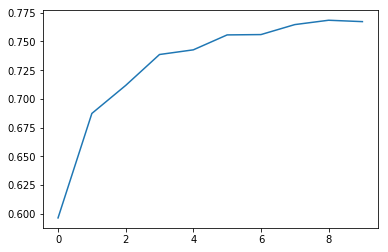

In [36]:
#R2 vs the # of trees 
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)])

#### OOB_ scores (out-of-the-bag) 
effectively a different validation set for each tree (rows that weren't used)

In [37]:
m = RandomForestRegressor(n_estimators = 40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.0258, 0.3511, 99.8539, 77.9837, -636.1234]


## 2. Reducing overfit

##### SUBSAMPLING

Rather than limit the total amount of data that our model can access (to speed up the process), let's limit it to a different random subset per tree. That way, given enough trees, the model can still see ALL the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before

In [11]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [39]:
set_rf_samples(50000) #when doing confidence intervals, we should
# use a subset to speed things up; 50k is a good starting point 
# we want a subset large enough so that everytime we run it 
# we get a close enough answer

#to turn this off: reset_rf_samples

In [40]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True) #not sure if oob_score is compatible with set_rf_samples
m.fit(X_train, y_train)
print_score(m)

[0.1971, 0.2504, 91.8845, 88.8067, 89.5463]


m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True) 
%time m.fit(X_train, y_train)
print_score(m)
#oob_score is higher b/c it was still looking at similar time periods 
#where as the validation set is a completely different time period 

#### Increase min_samples_leaf

In [41]:
#min_samples_leaf: stop at 3 leafs left; may have less accuracy per tree, but will likely generalize better
#1, 3, 5, 10, 25... generally works well (but larger datasets could go to thousands)
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, oob_score=True) 
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2min 6s, sys: 2.5 s, total: 2min 8s
Wall time: 21.4 s
[0.2056, 0.2487, 91.164, 88.9581, 89.3242]


#### Decrease max_features

## * model with all features*

In [14]:
#instead of looking at all possible levels of alll features, we look at all levels of a subset of features
#(max_features of 0.5 will look at half of the features for each node )
#if you use all the features on all of your trees, everyone is going to start at the best feature/split 
#that means all the trees will end up being pretty similar
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True) 
%time m.fit(X_train, y_train)
print_score(m) #[0.2332, 0.2624, 88.6303, 87.7056, 87.7761]

CPU times: user 2min 56s, sys: 1.31 s, total: 2min 57s
Wall time: 27.1 s
[0.1194, 0.2286, 97.0183, 90.6685, 91.1299]


## 3. Confidence based on tree VARIANCE (optional)

#look at the mean and std of each tree 
#using for-loop cannot be split into different CPUs and will be very slow
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:, 0]), np.std(preds[:, 0])  

instead:

In [43]:
#we can use FAST.ai function parallel_trees 
def get_preds(t): 
    return t.predict(X_valid)

%time preds = np.stack(parallel_trees(m, get_preds))

np.mean(preds[:, 0]), np.std(preds[:, 0])

CPU times: user 121 ms, sys: 248 ms, total: 369 ms
Wall time: 792 ms


(9.250536934100035, 0.23040492829839682)

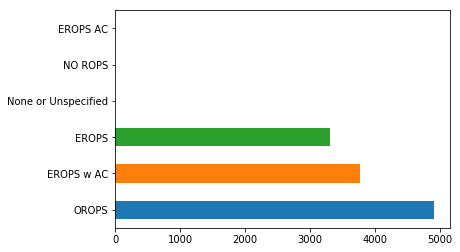

In [44]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [45]:
#focus on the bottom 3 levels of the Enclosure feature
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

#for Enclosure=EROPS, the avg SalePrice = 9.85 
# the model on average predicted 9.84 w/ std 0.275

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.839220,0.276006
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.578855,0.264814
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.689350,0.221334


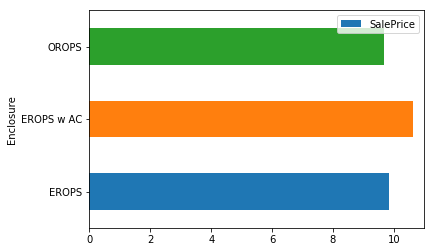

In [46]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11))

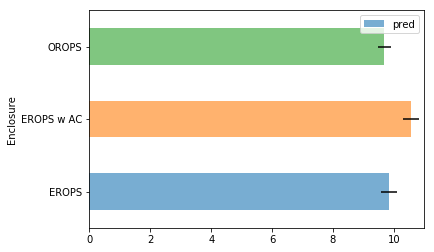

In [47]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11))

let's look at ProductSize

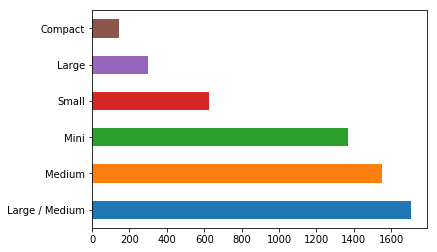

In [48]:
raw_valid.ProductSize.value_counts().plot.barh()

In [49]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0], as_index=True).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.872323,0.350038
Large,10.470589,10.375998,0.375681
Large / Medium,10.691871,10.651511,0.298442
Medium,10.681511,10.624791,0.284678
Mini,9.535147,9.562033,0.246610
Small,10.324448,10.316630,0.323180


In [50]:
#look at std as a % of the predicted prices 
(summ.pred_std/summ.pred).sort_values(ascending=False)

#our predictions are less accurate for Compact & Large 
#(not surprising b/c we had the fewest samples of these)

ProductSize
Large             0.036207
Compact           0.035457
Small             0.031326
Large / Medium    0.028019
Medium            0.026794
Mini              0.025791
dtype: float64

In [51]:
summ = x[flds].groupby(flds[0], as_index=False).mean()

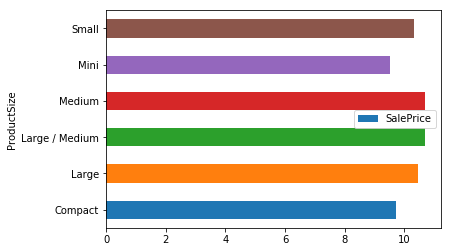

In [52]:
summ = summ[~pd.isnull(summ.SalePrice)]
summ.plot('ProductSize', 'SalePrice', 'barh')

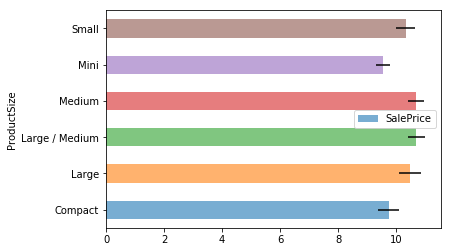

In [53]:
summ.plot('ProductSize', 'SalePrice', 'barh', xerr='pred_std', alpha=0.6)

## 3. Feature Importance

This is what you should focus on (after building a basic RF model as fast as you can) 

In [15]:
#an adaptation of m.feature_importances_
fi = rf_feat_importance(m, df_trn)
fi[:10]

,cols,imp
5,YearMade,0.172435
37,Coupler_System,0.118860
13,ProductSize,0.100866
14,fiProductClassDesc,0.083280
2,ModelID,0.060911
63,saleElapsed,0.052431
10,fiSecondaryDesc,0.043594
19,Enclosure,0.037922
39,Hydraulics_Flow,0.035728
38,Grouser_Tracks,0.033716


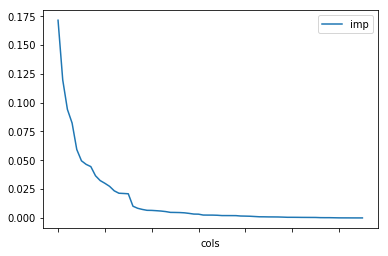

In [55]:
fi.plot('cols', 'imp', legend=True)

In [56]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

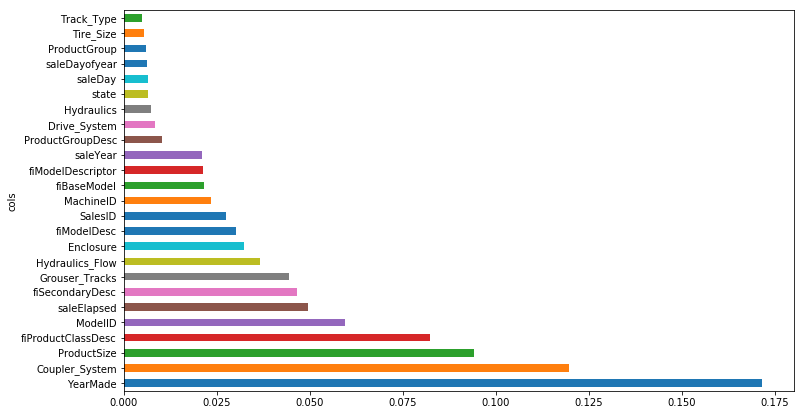

In [57]:
plot_fi(fi[:25])

issue of data leakage? 

In [16]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

24

In [17]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn) #shape: (389125, 25)

In [60]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, 
                          max_features=0.5, oob_score=True) 
m.fit(X_train, y_train)
print_score(m)
#all features: [0.2055, 0.2493, 91.1708, 88.9009, 89.4718]
#top 25: [0.2069, 0.2454, 91.0545, 89.2413, 89.4267]

[0.2072, 0.2462, 91.0299, 89.1772, 89.3859]


when you remove features, you're also removing sources of collinearity   
collinearty doesn't make your randomforest less predictive, but when you have all features in there, a few features might "share" collinearity; removing the redundant features will increase the fi of one variable

In [61]:
fi2 = rf_feat_importance(m, df_keep)
fi2

,cols,imp
0,YearMade,0.179386
1,Coupler_System,0.114651
2,ProductSize,0.101259
3,fiProductClassDesc,0.083184
4,ModelID,0.058239
5,saleElapsed,0.053541
9,Enclosure,0.042010
6,fiSecondaryDesc,0.041923
10,fiModelDesc,0.036606
7,Grouser_Tracks,0.036501


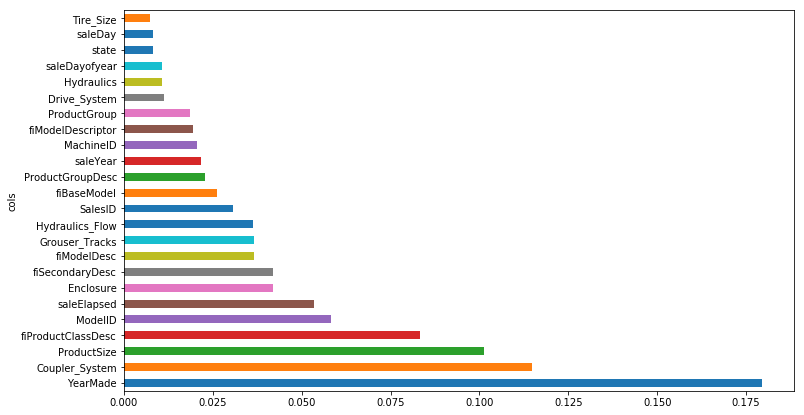

In [62]:
plot_fi(fi2)

so how does this work?  
how do we know how important YearMade is?  
randomly shuffle the YearMade column (so that we know it has no relationship to Y), and see how the model does... then does this for other variables; we do this instead of deleting it for speed - just using this one model

#### Few Notes on Hyperparameters  

to avoid overfitting:  
* decrease set_rf_samples
* increase min_samples_leaf  
* max_features to a fraction

#### set_rf_samples(20000)
* set_rf_samples(20000): picks 20k samples for each TREE... if you have 1m samples to begin with, and you take 20k of that to build a tree, if you grow it to leafnode of 1, that will be a depth of log2(20k), with 20k leafnodes at the very end of the tree (one for each sample)  --> if you decrease this number, overfitting will be less, but you will also get individually less predictive trees --> 
* you're trying to do 2 things: each tree is as accurate as possible (on the training set), and across the trees, correlation is as low as possible (avg error=0) 
* if you do not set_rf_samples, you will be bootstrapping (w/ replacement)  

#### min_samples_leaf = 2
* if you set min_samples_leaf to 2, depth will be log2(20k)-1 --> removing one layer; in the end you get 10k leafnodes at the end (actually we might not end up with 2 leafnodes at each tree, it won't split if any split has no impact on the Y: 'no more information left')
* as you increase msl, each tree will be less predictive, but correlation will also decrease  

#### max_features = 0.5 --> look into sqrt & log
* look at a fraction of features for each NODE (decision point), it'll pick randomly 50% of the features  
* important to decrease the correlation ---> otherwise you can have one feature that's so predictive that each tree will start w/ that split..trees are going to be pretty similar  
* half the time, that feature won't even be there 

## 4. One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.  
max_n_cats=7 means that one-hot encode all categorical variables with 7 or less levels

This could help the tree find the informative splits, but it could also make the model wrose; you might end up missing the possible groups that should stay together; (for age group, they individually may not make a difference, but if we take a look at 3 age groups together, a split makes sense)  

using max_n_cats does NOT differentiate ordinal data (which should not be encoded)

what if there is an ordinal feature you do not want encoded? 
--> turn it into a numeric column 
df_raw['UsageBand'].cat.categories

In [63]:
df_raw['UsageBand'] = df_raw['UsageBand'].cat.codes  #this is no longer a categorical data

In [64]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn) #(389125, 170)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                          max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
#no hot-encoding: [0.2055, 0.2493, 91.1708, 88.9009, 89.4718]
#hot encoded max_n_cat 7: [0.2078, 0.2544, 90.9723, 88.4377, 89.2383] --> worsened

[0.2085, 0.2558, 90.9176, 88.3157, 89.1699]


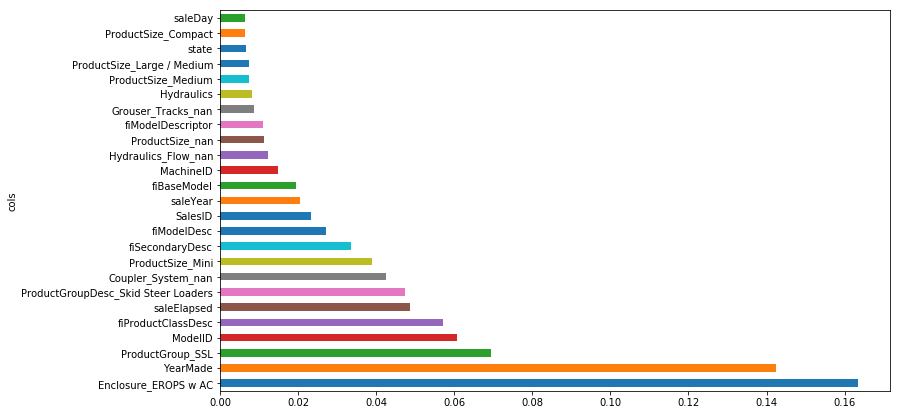

In [65]:
#however, this analysis is interesting for feature importance  
#we see below that Enclosure_EROPS w/ AC is the most important feature 
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25])

## 5. Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [66]:
#start with 25 top-features we got from Feature Importance

In [67]:
from scipy.cluster import hierarchy as hc

In [68]:
#randomforests do not care about linearity - they care about ordering 
#so we should look at rank correlation (as opposed to linear r)

corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr.shape #(24 by 24 varaibles)

(24, 24)

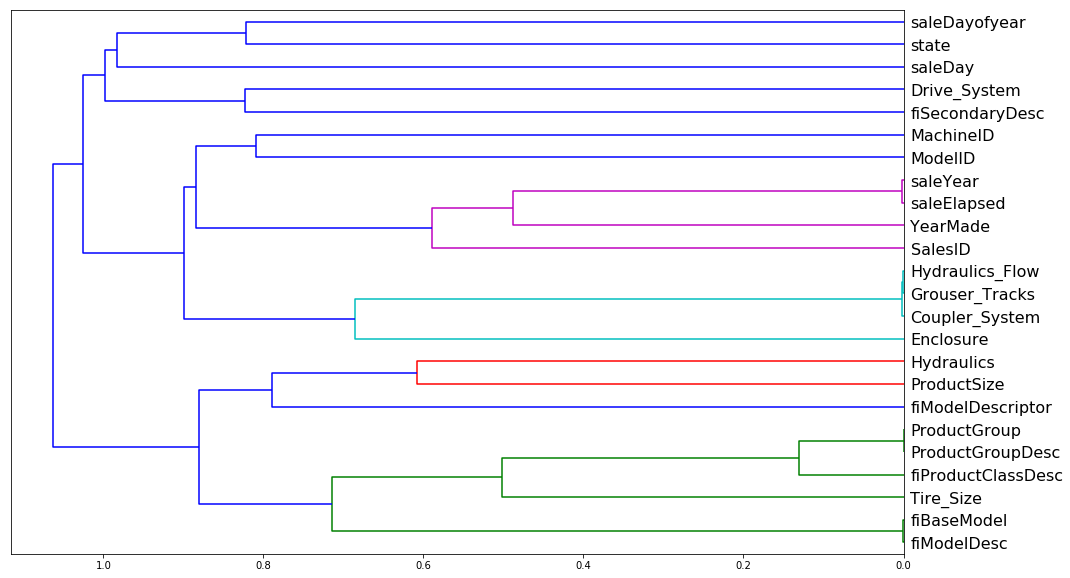

In [69]:
#create the dendrogram:

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

#the closer you're to the right, the more similar the variables are 

In [70]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                              max_features=0.5, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [71]:
#Here is our baseline
get_oob(df_keep)

0.8940689588401046

Now we try removing each variable one at a time 

ex. b/t saleYear & saleElapsed, 89.33 when we drop saleYear, 89.03 when we drop saleElapsed.... so we should drop the first

In [72]:
try_redund = ['saleYear', 'saleElapsed', 'fiBaseModel', 'fiModelDesc', 'Grouser_Tracks', 'Hydraulics_Flow', 'Coupler_System']
results = []
for c in try_redund: 
    results.append(get_oob(df_keep.drop(c, axis=1)))
redunds = np.column_stack((try_redund, results))

In [74]:
redunds

array([['saleYear', '0.8929780986322963'],
       ['saleElapsed', '0.890524588749804'],
       ['fiBaseModel', '0.8927379848653743'],
       ['fiModelDesc', '0.8924241597752882'],
       ['Grouser_Tracks', '0.8946139942634618'],
       ['Hydraulics_Flow', '0.8941940508949213'],
       ['Coupler_System', '0.894140185599383']], dtype='<U32')

In [75]:
#try to remove 1 of each group 
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8919261759942688

In [19]:
#looks good, so let's do that 
d
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [77]:
X_train.shape

(389125, 21)

In [78]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [20]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols] ## (401125, 22)

In [80]:
reset_rf_samples() #go back to bootstrap instead of using a subsample

In [81]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1256, 0.2264, 96.7013, 90.8422, 90.8696]


I have removed all the features based on either feature importance, or that they were redundant - model didn't really change when they were removed 

## 6. Partial dependence

In [82]:
#!pip install pdpbox
from pdpbox import pdp
from plotnine import *

In [83]:
set_rf_samples(50000)

use one-hot encoding again to looks at feature importance 

In [84]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat = 7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

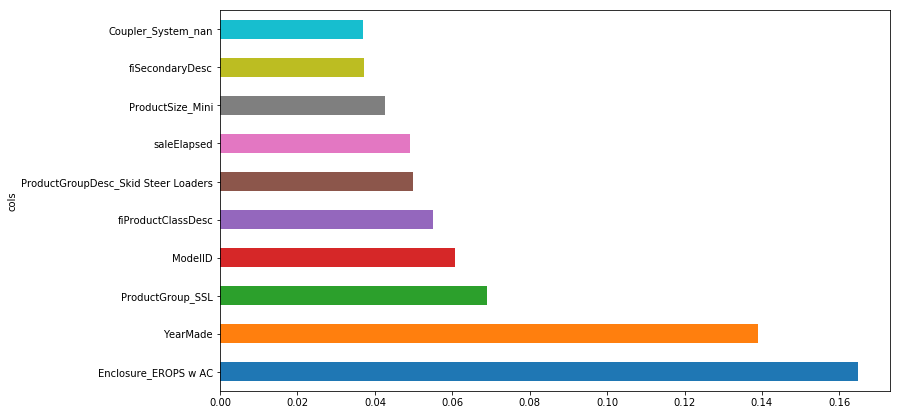

In [85]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

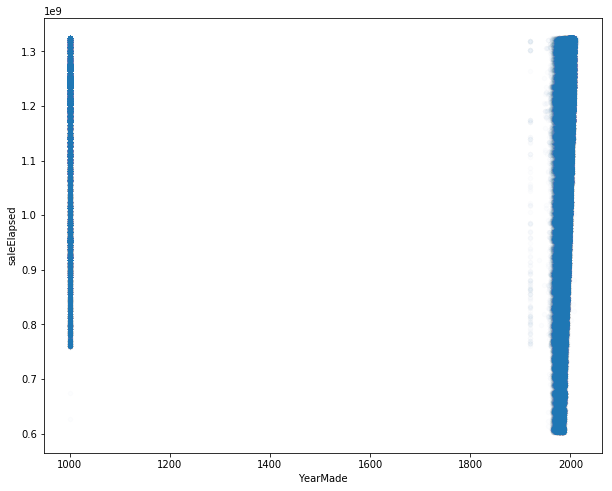

In [86]:
#start w/ YearMade - it seems likely that it'll be related to saleElapsed

df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8))

In [87]:
#seems strange that there are products made in the Year 1000, let's set that aside for now...
#grab 500 random samples 

x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

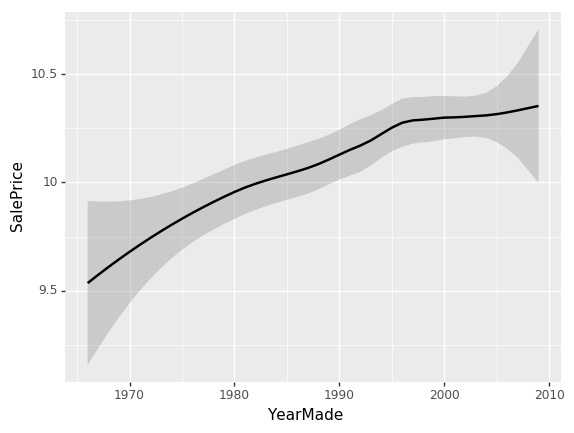

<ggplot: (-9223363288774555823)>

In [88]:
ggplot(x_all, aes('YearMade', 'SalePrice')) + stat_smooth(se=True, method='loess')

We see that generally SalePrice is higher for more recent products, but that is not always the case; --> what we want is to see, everything else equal 

How?  

let's say we want to know, everything else unchanged, and we want to know the Price of a bulldozer made in 1960 --> take our model, override the column YearMade with 1960, and have the model predict the Price 

In [89]:
x = get_sample(X_train[X_train.YearMade>1930], 500)
x.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Differential_Type_Locking', 'Differential_Type_No Spin',
       'Differential_Type_Standard', 'Differential_Type_nan',
       'Steering_Controls_Command Control', 'Steering_Controls_Conventional',
       'Steering_Controls_Four Wheel Standard', 'Steering_Controls_No',
       'Steering_Controls_Wheel', 'Steering_Controls_nan'],
      dtype='object', length=170)

In [90]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                       cluster = clusters is not None, n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4d1ffa6ac8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4d1ff8c9b0>})

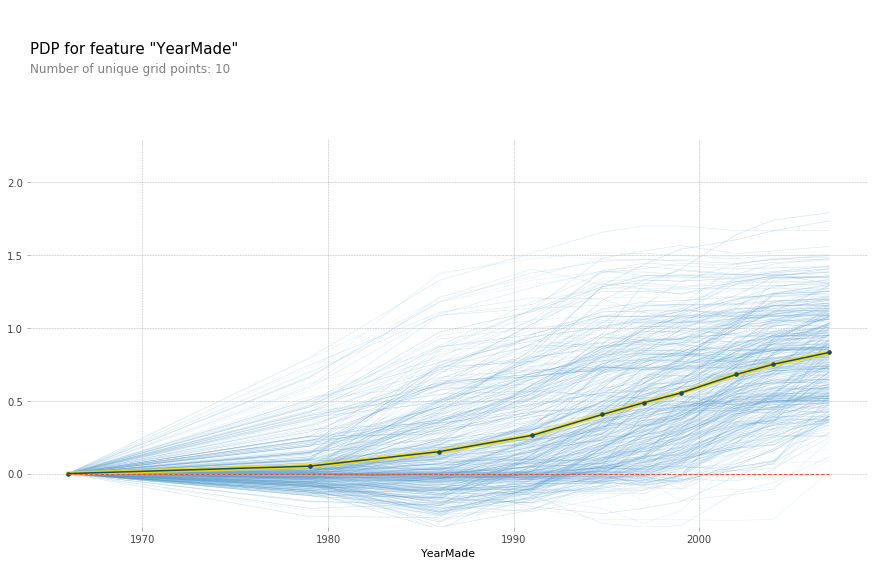

In [91]:
plot_pdp('YearMade')

each of these light blue lines, is an actual sample; for each m, if it were made in 1960, the price would've been... 1970, the price would've been... thus the line

the dark line is the average  

so for the time period where we have a decent amount of data (from 1990 on), it's pretty much a straightline -- which makes sense.. everything else equal, the newer products are sold for more 

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4d1ec46400>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4d1eb69588>})

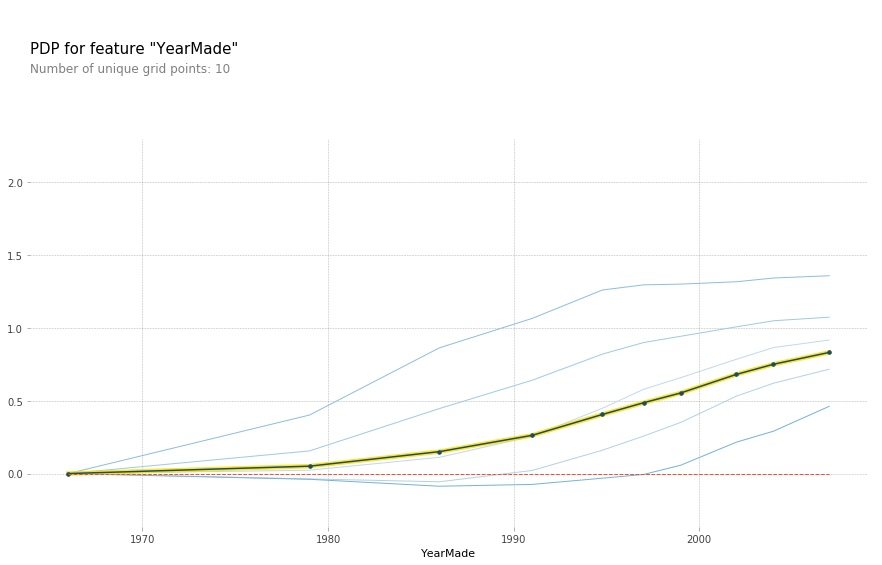

In [92]:
plot_pdp('YearMade', clusters=5)

#by looking at clusters, we see the 5 general shapes that we see... 

the clusters tell us that there are some vehicles whose values after 1950s flattened... and some others the opposite is true   

why do we need to know these? isolate the impact of one variables 

### what about interactions? 

feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats)

#https://github.com/SauceCat/PDPbox/commit/73c69665f1663b53984e187c7bc8996e25fea18e

?pdp.pdp_interact_plot

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4d1ebc4208>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4d1eaeaef0>})

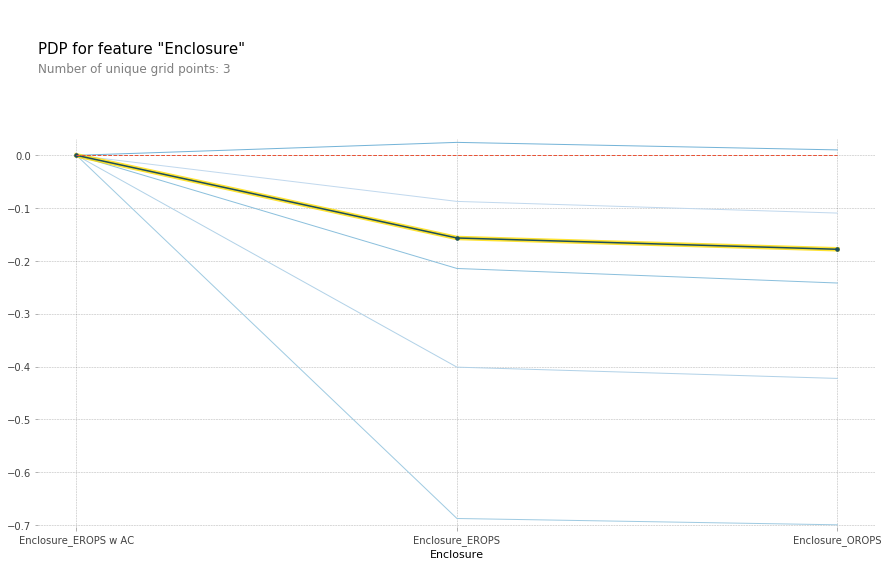

In [93]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

#you can see that w/ AC is higher priced 

In [21]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

#(df_keep now has 23 columns)

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
X_train, X_valid = split_vals(df_keep, n_trn) #(389125, 23)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train)
#plot_fi(rf_feat_importance(m, df_keep));

NameError: name 'plot_fi' is not defined

## 7. Tree interpreter ***

In [96]:
from treeinterpreter import treeinterpreter as ti

In [24]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

these have the same shape, but X_train is already encoded 
df_train.head() #w/ strings 
X_train.head()  #all encoded 

In [25]:
row = X_valid.values[None,0]; #this gets the 1st row, but in 2D array 
row #1x23

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          0,
                 1,       3232,    4364751,    2300944,          0,          4,          0,         12,
                35,         16,        259,          4,          0,         11]])

In [99]:
prediction, bias, contributions = ti.predict(m, row)

#check: prediction ≈ bias + feature_contributions 
prediction[0][0] == bias[0] + sum(contributions[0])

#prediction.shape, bias.shape, contributions.shape
#((1, 1), (1,), (1, 23))

True

In [100]:
idxs = np.argsort(contributions[0]) #sort by feature contribution
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.49131382999986084),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.1896099784342601),
 ('age', 11, -0.08150577011888638),
 ('Enclosure', 'EROPS', -0.06798283755441181),
 ('fiModelDesc', 'KX1212', -0.047409725754258544),
 ('fiSecondaryDesc', nan, -0.04249506712720197),
 ('fiModelDescriptor', nan, -0.04082753179713072),
 ('MachineID', 2300944, -0.0184778398419009),
 ('SalesID', 4364751, -0.012566924205033025),
 ('Tire_Size', nan, -0.010348474417057352),
 ('saleDayofyear', 259, -0.00937054195527196),
 ('saleDay', 16, 0.0007389559236925969),
 ('state', 'Ohio', 0.002775191741406946),
 ('ProductGroupDesc', 'Track Excavators', 0.005199723562338265),
 ('ProductGroup', 'TEX', 0.008192521731383007),
 ('Drive_System', nan, 0.008259560897861418),
 ('saleElapsed', 1284595200, 0.01079128048067104),
 ('Hydraulics_Flow', nan, 0.0235843120880455),
 ('ModelID', 665, 0.02755737341438578),
 ('Hydraulics', 'Standard', 0.027650958669641977),

Interpretation: RandomForest is not a blackbox  
Our prediction was: 9.4321  
Bias was 10.1   
from there, the fact that it was a Mini ProductSize subtracted -0.42, etc... and that YearMade was 1999 addd 0.088... 

## 8. Extrapolation
##### dealing with OOB > validation score

Problem of Extrapolation (to a new time period)   
	• when you have linear regression, you can find a relatinoship between time and Price, but a RF cannot do that  
	• the tree cannot say that: next month, price will be higher still   
	• so we should stop using TIME variables as predictors   
	• are there other variables that can inform us? 


In [26]:
#Here is our model now (w/ 23 features): 

X_train, X_valid = split_vals(df_keep, n_trn) #(389125, 23)
m = RandomForestRegressor(n_estimators=40, 
                          min_samples_leaf=3, 
                          max_features=0.5, 
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1245, 0.2256, 96.7604, 90.9125, 90.8832]


[0.2078, 0.2484, 90.9757, 88.9768, 89.3305]   
valid_score = 88.9768  
OOB_score = 89.3305  
^ this is not what we should expect in the end   
since OOB is predicting samples based on one single tree, validation should be better b/c it's looking at the whole forest

Why OOB_score > validation?  this is mostly b/c of temporal order  
the OOB contains periods of dates that tree has seen (the validation is for a new timeframe) - so we're good at predicting the past   

Solution: remove time-related data

#### What's the difference b/t our training and validation set?  
(that will tell us which components have a strong temporal component - these components will probably also be irrelevant by the time we implement the model)

In [28]:
# we predict which row is in the training vs validation? 
df_ext = df_keep.copy()
df_ext['is_validation'] = 1
df_ext['is_validation'][:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_validation')

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [29]:
m = RandomForestClassifier(n_estimators=40, 
                          min_samples_leaf=3, 
                          max_features=0.5,
                         n_jobs=-1,
                         oob_score=True)
m.fit(x, y)
m.oob_score_
#this is a strong

0.9999975070115301

In [30]:
fi = rf_feat_importance(m, x)
fi[:10]
#we see that SalesID, saleElapsed, MachineID, all have a strong temporal component 

,cols,imp
10,SalesID,0.796233
5,saleElapsed,0.148688
11,MachineID,0.046281
4,ModelID,0.001994
9,fiModelDesc,0.001987
18,saleDayofyear,0.001526


In [34]:
feats=['SalesID', 'saleElapsed', 'MachineID']
#are these features very different from training set and val set? 

In [36]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [39]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [40]:
#what happens to be model if I drop these 3 features?
x.drop(feats, axis=1, inplace=True)

In [41]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_ #still temporal features in there... 

0.9816216889996884

In [42]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.234310
0,YearMade,0.192390
15,saleDayofyear,0.156476
4,ModelID,0.071021
14,saleDay,0.064741
13,state,0.056723
8,fiModelDesc,0.055980
3,fiProductClassDesc,0.028679
7,Enclosure,0.028442
12,Hydraulics,0.023186


In [43]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [44]:
set_rf_samples(50000)

In [46]:
X_train, X_valid = split_vals(df_keep, n_trn) 
m = RandomForestRegressor(n_estimators=40, 
                          min_samples_leaf=3, 
                          max_features=0.5, 
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2075, 0.2483, 90.9982, 88.9927, 89.3407]


feats = all time dependent features   
we still want them in the RF if they're important.. but if they're not, and there are other variables that can predict the same, then that’s better (fewer variables that depend on time) 


In [47]:
for f in feats: 
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.2098, 0.2465, 90.804, 89.1486, 89.1823]
saleElapsed
[0.2142, 0.2541, 90.4136, 88.4732, 88.7129]
MachineID
[0.2073, 0.2475, 91.0176, 89.0617, 89.4487]
age
[0.2093, 0.25, 90.8404, 88.841, 89.1788]
YearMade
[0.209, 0.2525, 90.8706, 88.614, 89.2197]
saleDayofyear
[0.2088, 0.2435, 90.8856, 89.4152, 89.2816]


for every feature, drop each one, one at a time, retrain and print score 
if we remove SalesID, then validation score goes up (but oob does not, b/c statistically it is still important); so this is a variable that is time dependent, but removing it is ok b/c there are other variables that still contain the important information   

we should remove SalesID 

but salesElapsed did not improve 

get rid of the ones that we know getting rid the, results will be better 


When we removed these, validation scores got BETTER:   
SalesID, MachineID, saleDayofYear --- drop these

In [49]:
reset_rf_samples()

In [50]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1385, 0.2177, 95.9904, 91.5397, 90.9148]


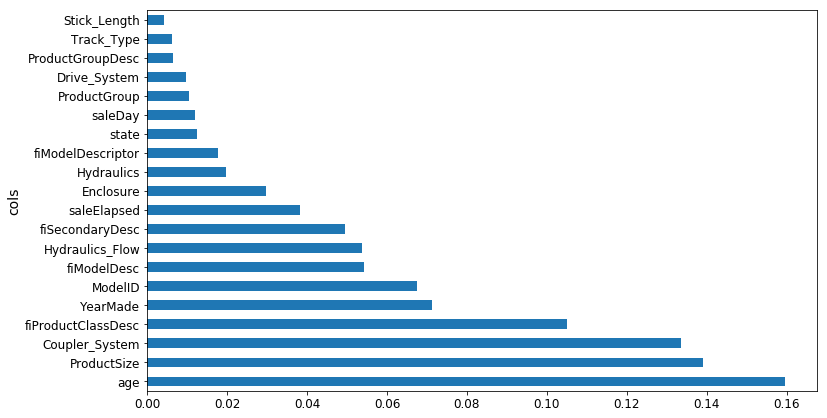

In [79]:
plot_fi(rf_feat_importance(m, X_train));

In [80]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [51]:
m = RandomForestRegressor(n_estimators=160, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 4min 38s, sys: 668 ms, total: 4min 38s
Wall time: 39.6 s
[0.137, 0.2162, 96.0784, 91.6489, 91.2673]


## FYI: on Extrapolation
#### RandomForests do NOT extrapolate -- here is how we can test it

In [90]:
x = np.linspace(0, 1)  #gives you 50 evenly spaced #s b/t 0,1
x

array([0.     , 0.02041, 0.04082, 0.06122, 0.08163, 0.10204, 0.12245, 0.14286, 0.16327, 0.18367, 0.20408,
       0.22449, 0.2449 , 0.26531, 0.28571, 0.30612, 0.32653, 0.34694, 0.36735, 0.38776, 0.40816, 0.42857,
       0.44898, 0.46939, 0.4898 , 0.5102 , 0.53061, 0.55102, 0.57143, 0.59184, 0.61224, 0.63265, 0.65306,
       0.67347, 0.69388, 0.71429, 0.73469, 0.7551 , 0.77551, 0.79592, 0.81633, 0.83673, 0.85714, 0.87755,
       0.89796, 0.91837, 0.93878, 0.95918, 0.97959, 1.     ])

RandomForest only accepts 2D arrays for X (and 1D for y)  
x[:, None] --> this is one way to do it (50,1)  
x[..., None] --> is a more generalized way (works in higher dimensions, ie to turn 2D into 3D)  
x[None] --> same as [None, :] (1,50)


In [84]:
y = x + np.random.uniform(-0.2, 0.2, x.shape)

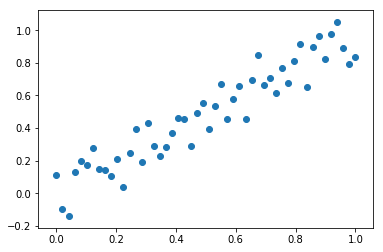

In [91]:
plt.scatter(x, y)

In [92]:
x = x[..., None]

In [86]:
x_trn, x_val = x[:40], x[40:]
y_trn, y_val = y[:40], y[40:]

In [98]:
m = RandomForestRegressor().fit(x_trn, y_trn)

/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


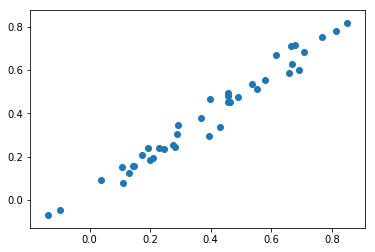

In [99]:
#from the training set, y_predicted and y_actual should be very close
plt.scatter(y_trn, m.predict(x_trn))

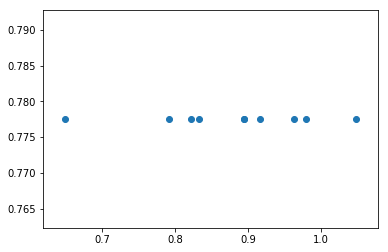

In [100]:
#but for the val set, RF has NEVER see this range of X before, the closest it has seen was 
#so it will always predict higher range of values to be the largest x it has seen
plt.scatter(y_val, m.predict(x_val))